# Read and Plot Remote Data Example

<br>This program will read the latest 00z GFS model run and plot the 2-meter air temperature

Concepts Covered:
* Remote access of netcdf file
* Subset closest grid point to a lat/lon observation point
* Create a georeferenced plot

Conda Environment: py37_example
To create this environment from the environment specifications file:
conda create -n py37_example --file py37_example_file_specification.txt

Created by: Nick Dawson aka AtmoGuy
<br> 2019/07/31



In [1]:
# Import required libraries
import datetime as dt
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [2]:
# Initialize Functions

def create_lat_lon():
    """
    Function to create latitude and longitude arrays
    Metadata available from remote_url + .info

    Parameters
    ----------

    Attributes
    ----------

    Returns
    -------
    lats: 2-D Numpy array
        model latitude values
    lons: 2-D Numpy array
        Model longitude values with west values as negative (not 0-360)
    """

    lats = np.arange(-90, 90.25, 0.25)
    lons = np.arange(0, 360, 0.25)

    # make the arrays 2-D instead of 1-D
    lons, lats = np.meshgrid(lons, lats)

    # convert lon from degrees east to degrees east and west
    lons[lons>180] = lons[lons>180]-360
    return(lats, lons)

def subset_model(obs_lat, obs_lon, data, model_lats, model_lons):
    """
    Purpose
    -------
    Finds the index of the model grid box closest to the observation point

    Parameters
    ----------
    obs_lat: float
        Latitude point of observation
    obs_lon: float
        Longitude point of observation [west is negative]
    data: 2-D numpy array
        The model quantity you wish to subset
    model_lats: 2-D numpy array
        2-D array of model latitudes
    model_lons: 2-D numpy array
        2-D array of model longitudes

    Attributes
    ----------
    a: 2-D numpy array
        Distance of observation grid point to all model grid points


    Returns
    -------
    i_point: int
        longitude index for model grid box
    j_point: int
        latitude index for model grid box
    out_data: float
        Value of the observation at grid point [i,j]
    """
    # find index of model grid box closest to observation point
    a = abs(model_lats-obs_lat)+abs(model_lons-obs_lon)
    # get i and j locations within the data matrix
    i_point, j_point = np.unravel_index(a.argmin(),a.shape)
    # subset the data
    out_data = data[i_point, j_point]
     
    return(out_data, i_point, j_point) 

## Get yesterday's date to avoid errors if today's [utc] run isn't finished yet and then format it.


In [3]:
current_date = dt.datetime.utcnow() - dt.timedelta(days=1)
# reformat datetime object as a string with a specific format
current_date = dt.datetime.strftime(current_date, '%Y%m%d') 
print('Current date is {}'.format(current_date))

Current date is 20190731


In [4]:
# remote path is in the form https://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfsYYYYMMDD/gfs_0p25_00z
remote_url = "https://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfs{}/gfs_0p25_00z"
# add current_date into the string
remote_url = remote_url.format(current_date)
# the .format(var) syntax will place var into the {} spot in remote_url. 
# Can have multiple {} in a string. Constraint is you need as many var's as {}'s
print('Let\'s fetch {}'.format(remote_url))

dataset = nc.Dataset(remote_url)


Let's fetch https://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfs20190731/gfs_0p25_00z


## Next we will create the latitude and longitude arrays
## Lat/Lon information provided on info website
* Info website template-> https://nomads.ncep.noaa.gov:9090/dods/gfs_0p25/gfsYYYYMMDD/gfs_0p25_00z.info
* Replace YYYYMMDD with the current date


In [5]:
lats, lons = create_lat_lon()

## I looked at the info website (template provided above) to see that the variable I want is 'tmp2m'. 


## Let's look at the variable info within the dataset

In [6]:
dataset.variables['tmp2m']

<class 'netCDF4._netCDF4.Variable'>
float32 tmp2m(time, lat, lon)
    _FillValue: 9.999e+20
    missing_value: 9.999e+20
    long_name: ** 2 m above ground temperature [k] 
unlimited dimensions: 
current shape = (81, 721, 1440)
filling off

## Now let's remotely grab the first 5 time steps [Time, Lat, Lon] of 2-m air temperature from the latest 00z GFS run


In [7]:
# This step takes a little while as the remote server is subsetting the data for you
t2m = dataset.variables['tmp2m'][0:5,:,:]

In [8]:
print(lats.shape)
print(t2m.shape)

(721, 1440)
(5, 721, 1440)


### Now it's time to create your first figure!

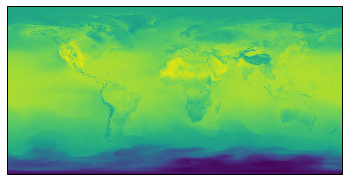

In [9]:
fig = plt.figure()
# create a georeferenced axis
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
# plot the first [0-based index] time step
ax.pcolormesh(lons, lats, t2m[0,:,:]) # use contourf if you want smoothing
# make the plot fancy
#ax.coastlines()
#ax.gridlines()
plt.show()

### That plot is kind of boring. You get the idea, but let's make it look better. We can grab state outlines in the next cell.

## As of 2019/07/31 the website that hosts the state outlines is offline. There are ways around this but eventually the following line will work again once the site is online

In [10]:
# grab state outlines
states_50m = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')

## Instead of using states_50m, we will use GSHHSFeature which includes country outlines

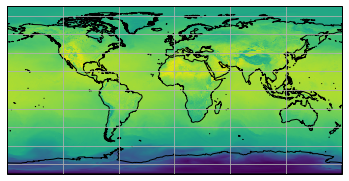

In [11]:
# create a figure
fig = plt.figure()
# create a georeferenced axis
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
# plot the first [0-based index] time step
ax.pcolormesh(lons, lats, t2m[0,:,:]) # use contourf if you want smoothing
# make the plot fancy
ax.gridlines()
#ax.add_feature(states_50m) # broken at the moment
ax.add_feature(cfeature.GSHHSFeature(edgecolor='k'))
plt.show()

## Lets zoom into the USA

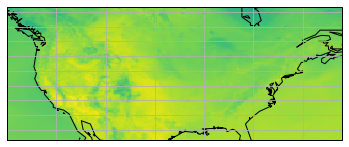

In [12]:
# set a bounding box
ulx = -130
uly = 50
lrx = -62
lry = 28

# create a figure
fig = plt.figure()
# create a georeferenced axis
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
# plot the first [0-based index] time step
ax.pcolormesh(lons, lats, t2m[0,:,:]) # use contourf if you want smoothing
# make the plot fancy
ax.gridlines()
ax.set_extent([ulx, lrx, lry, uly])
#ax.add_feature(states_50m) # broken at the moment
ax.add_feature(cfeature.GSHHSFeature(edgecolor='k'))
plt.show()


### Now lets subset the dataset for a point. Boise seems like a good spot!

In [13]:
boise_lat = 43.618
boise_lon = -116.215

## Remember, the function that subsets the gridded data takes the following data: subset_model(obs_lat, obs_lon, data, model_lats, model_lons)

## And returns the data point, i_loc, and j_loc

In [14]:
data_point, i_loc, j_loc = subset_model(boise_lat, boise_lon, t2m[0,:,:], lats, lons)

print(data_point)

307.4


## Wow that's hot! Oh wait, it's in Kelvin. How do we know this?
## We visited the info website and found out.
## Most netCDF4 files will provide units which can be found via:
* dataset.variables['varname'].units

In [15]:
# conver K to C
data_point = data_point - 273.15
print('Temperature in degC: {:.2f}'.format(data_point))

Temperature in degC: 34.25


## How do we know we pulled data from the right point? One way is to check the i,j locations from the gridded lat/lon and see if it matches our expectations

In [16]:
print('Boise lon/lat pair:            {:.2f}, {:.2f}'.format(boise_lon, boise_lat))
print('Nearest grid box lon/lat pair: {}, {}'.format(lons[i_loc, j_loc], lats[i_loc, j_loc]))

Boise lon/lat pair:            -116.22, 43.62
Nearest grid box lon/lat pair: -116.25, 43.5


## That's pretty close! Now lets plot the point on the map as one last check that it's in the right location

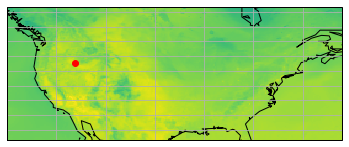

In [17]:
# create a figure
fig = plt.figure()
# create a georeferenced axis
ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
# plot the first [0-based index] time step
ax.pcolormesh(lons, lats, t2m[0,:,:]) # use contourf if you want smoothing
ax.scatter(lons[i_loc, j_loc], lats[i_loc, j_loc], color='red')
# make the plot fancy
ax.gridlines()
ax.set_extent([ulx, lrx, lry, uly])
#ax.add_feature(states_50m) # broken at the moment
ax.add_feature(cfeature.GSHHSFeature(edgecolor='k'))
plt.show()

## Would you look at that! The red dot definitely is where Boise is located.

## This is the end of the example